<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/lsf_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# if you're running this locally not on linux, this apt install probably won't work
!apt-get update
!apt install -qq enchant

!pip install praw
!pip install vaderSentiment
!pip install pycorenlp
!pip install pyenchant
!pip install alt-profanity-check

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [700 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.laun

In [ ]:
from profanity_check import predict, predict_prob
import praw
import csv
import time
import re
import os
from pycorenlp.corenlp import StanfordCoreNLP
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from itertools import groupby, product
import warnings
import enchant
import pickle
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from scipy.signal import detrend

# lexicon for known english words
words = enchant.Dict("en")
is_known_word = words.check
dt_str = datetime.datetime.strftime(datetime.datetime.now(), format='%Y%m%d%H%M%S')

In [ ]:
## coreNLP sent. analysis
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def getSentiment(text):
    ## connect to CoreNLP server
    host = "http://localhost"
    port = "9000"
    nlp = StanfordCoreNLP(host + ":" + port)

    # annotate text
    output = nlp.annotate(
    text,
    properties={
        "outputFormat": "json",
        "annotators": "sentiment"
    }
    )

    # grab sentiment
    total_sent = 0
    n = 0
    for sen in output['sentences']:
        total_sent = total_sent + int(sen["sentimentValue"])
        n = n + 1

    # avoid divide by 0
    if n != 0:
        return total_sent / n
    else:
        raise Exception("Comment length 0")

def remove_consecutive_dups(s):
    return re.sub(r'(?i)(.)\1+', r'\1', s)

def all_consecutive_duplicates_edits(word, max_repeat=float('inf')):
    chars = [[c*i for i in range(min(len(list(dups)), max_repeat), 0, -1)]
             for c, dups in groupby(word)]
    return map(''.join, product(*chars))

def isnan(string):
  """
  checks if input is a nan (works for strings)
  """
  return string != string

def remove_elongations_bro(line):
  """
  Removes elongated words.
  """
  if (isnan(line)) | (line is None):
    warnings.warn('This is a nan or NoneType line...\n')
    return None

  else:
    output = [next((e for e in all_consecutive_duplicates_edits(s)
                    if e and is_known_word(e)), remove_consecutive_dups(s))
              for s in re.split(r'(\W+)', line)]
    line_no_elongs = ''.join(output)
    return line_no_elongs

def censor_profanity(comment_text, profanity_threshold=0.9):
  """
  Replaces profanity using a (probably) inefficient use of the alt-profanity-filter.

  Input: comment_text (str)
  Output: comment text with profane words censored
  """
  repl_text = [(x,f"{x[0]}{''.join(['*' for x in range(len(x)-1)])}") for x in comment_text.split(' ') if predict_prob([x])[0]>profanity_threshold]
  comment_text_censored = comment_text
  for text in repl_text:
    comment_text_censored = comment_text_censored.replace(text[0], text[1])
  return comment_text_censored

def clean_comment(comment):
  # GETS COMMENT AND METADATA
  comment_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(comment.created_utc))
  comment_id = comment.id

  # grab text and remove new lines
  comment_text = comment.body.replace("\n", "")
  comment_text = comment_text.replace("\t", "")
  comment_text = comment_text.split('http')[0]
  if len(comment_text) == 0:
    comment_text = '[Link removed]'
  comment_text = re.sub(r"[^a-zA-Z0-9 !?,.()]+", '', comment_text)
  comment_length = len(comment_text)

  comment_text_clean = remove_elongations_bro(comment_text.lower())
  comment_text_censored = censor_profanity(comment_text)
  return comment_time, comment_id, comment_text_clean, comment_text_censored

def get_sentiment(comment, toxicity_models, vec):
  comment_time, comment_id, comment_text_clean, comment_text_censored = clean_comment(comment)
  label_cols = ['toxic', 'severe_toxic', 'obscene',
                'threat', 'insult', 'identity_hate']
  sentiment = vader.polarity_scores(comment_text_clean)['compound']
  test = pd.Series(comment_text_clean)
  test_x = vec.transform(test)
  preds = np.zeros((len(test), len(label_cols)))
  for idx, (k,val) in enumerate(toxicity_models.items()):
    model = val[0]
    r = val[1]
    preds[:, idx] = model.predict_proba(test_x.multiply(r))[:,1]


  df_out = pd.DataFrame([[comment_id, comment_time, comment_text_censored, sentiment] + preds.tolist()[0]], columns=['cid', 'dt', 'comment', 'sentiment']+label_cols)
  return df_out

def tokenize(s): return re_tok.sub(r' \1 ', s).split()

def pr(y_i, y, trn_term_doc):
    p = trn_term_doc[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y, trn_term_doc):
    y = y.values
    r = np.log(pr(1,y,trn_term_doc) / pr(0,y,trn_term_doc))
    m = LogisticRegression(C=4)
    x_nb = trn_term_doc.multiply(r)
    return m.fit(x_nb, y), r

def make_dt(x):
  y = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))
  return y

def make_scalers(df):
  sentiment_scaler = MaxAbsScaler()
  sentiment_scaler.fit(df[['sentiment']])

  toxic_scaler = MaxAbsScaler()
  toxic_scaler.fit(df[['toxic']])

  severe_toxic_scaler = MaxAbsScaler()
  severe_toxic_scaler.fit(df[['severe_toxic']])

  obscene_scaler = MaxAbsScaler()
  obscene_scaler.fit(df[['obscene']])

  threat_scaler = MaxAbsScaler()
  threat_scaler.fit(df[['threat']])

  insult_scaler = MaxAbsScaler()
  insult_scaler.fit(df[['insult']])

  identity_hate_scaler = MaxAbsScaler()
  identity_hate_scaler.fit(df[['identity_hate']])
  return sentiment_scaler, toxic_scaler, severe_toxic_scaler, obscene_scaler, threat_scaler, insult_scaler, identity_hate_scaler

def plot_score(df, col, ax=None):
  import warnings
  warnings.filterwarnings('ignore')
  val = df[col].values[0]
  vals = [-100, 0 ,100]+[val]
  _vals = [0]*len(vals)
  vals  = [[x,y,100] for x,y in zip(vals, _vals)]
  df_plt = pd.DataFrame(vals, columns=['x', 'y', 's'])
  df_plt.loc[3, 's'] = 1000

  ax = sns.scatterplot(data=df_plt, x='x', y='y', hue='x', palette='coolwarm', zorder=2, edgecolor='k', alpha=1, size='s', sizes=(200,1000), ax=ax)
  sns.lineplot(range(-100 ,100), [0]*len(list(range(-100 ,100))), zorder=1, c='k', ax=ax)
  ax.text(df_plt.loc[3, 'x'], 0.03, round(df_plt.loc[3, 'x']), ha='center', va='center', fontsize=20)
  ax.text(0, -0.03, f"{col}", ha='center', va='center', fontsize=14)
  ax.legend().set_visible(False)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  sns.despine(left=True, bottom=True)
  ax = plt.gca()
  # plt.show()
  warnings.filterwarnings('default')
  return ax

def median_shift(df):
  for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    med = df[col].median()
    df[col] = df[col].sub(med)
  return df

In [ ]:
## INIT GLOBAL VARS
chunk_size = 5000
num_chunks = 0

## INIT REDDIT INSTANCE
auth_file= open('drive/My Drive/lsf/auth.txt')
auth_file = auth_file.read()
auth_file = auth_file.split(', ')
client_id = auth_file[0]
client_secret = auth_file[1]
username = auth_file[2]
pw = auth_file[3]

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent="lsf toxicity levels 'by' nickwan",
                     username=username,
                     password=pw,
                     check_for_async=False)

## INIT PROFANITY FILTER

## INIT VADER SENTIMENT
vader = SentimentIntensityAnalyzer()

## INIT TEXTCLEAN R

## Note: i don't think we need this since i rewrote the elongation func -nw 4-20-21
# r_library_directory = 'path/to/r/library' #looks like C:/Users/caiob/Documents/R/win-library/3.6
# textclean = importr('textclean', lib_loc = r_library_directory)
# importr('stringi', lib_loc = r_library_directory)

## INIT SAVE DIRECTORY
# comments_directory = "path/to/directory"
comments_directory = 'drive/My Drive/lsf'

In [ ]:
with open(f'{comments_directory}/toxicity.model', 'rb') as handle:
  toxicity_models = pickle.load(handle)

with open(f'{comments_directory}/toxicity-tfidf.vec', 'rb') as handle:
  vec = pickle.load(handle)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
cols = ["thread", "flair", "upvotes", "upvote_ratio", "num_comments", 'cid',
        'dt', 'comment', 'sentiment', 'toxic', 'severe_toxic', 'obscene',
        'threat', 'insult', 'identity_hate']
df = pd.DataFrame(columns=cols)
query =  reddit.subreddit('LivestreamFail').top(time_filter='day', limit=None)
break_lim = 0
for idx, post in tqdm(enumerate(query)):
  thread = post.title
  try:
    flair = post.link_flair_richtext[1]['t']
  except:
    flair = post.link_flair_text
  upvotes = post.ups
  upvote_ratio = post.upvote_ratio
  num_comments = post.num_comments
  comments = post.comments
  comments.replace_more(limit=None)
  for comment in comments.list():
    if '[removed]' in comment.body:
      continue
    elif 'CLIP MIRROR' in comment.body:
      continue

    df_out = get_sentiment(comment, toxicity_models, vec)
    df_out['thread'] = thread
    df_out['flair'] = flair
    df_out['upvotes'] = upvotes
    df_out['upvote_ratio'] = upvote_ratio
    df_out['num_comments'] = num_comments
    df = df.append(df_out, ignore_index=True)
  time.sleep(1)
df.to_csv(f'{comments_directory}/{dt_str}.csv', index=False)
df_day = df.copy()

0it [00:00, ?it/s]

In [ ]:
df_day.sample(5)

,thread,flair,upvotes,upvote_ratio,num_comments,cid,dt,comment,sentiment,toxic,severe_toxic,obscene,threat,insult,identity_hate
1204,Uber driver gets mad at Jinny for not staying ...,Jinnytty | Just Chatting,863,0.80,456,hbunwlx,2021-09-06 20:45:17,and welcome to my guide!,0.5093,0.009474,0.000675,0.004854,0.000170,0.004645,0.000736
342,WoW streamer losing his mind,Warning: Loud,1924,0.95,340,hbsm2ty,2021-09-06 10:41:31,Absolutely f****** based. The man just wants t...,0.0000,0.993982,0.004899,0.993283,0.000283,0.167192,0.005207
864,Watchmeblink182 is a bit tipsy while recording...,watchmeblink | Just Chatting,1796,0.90,89,hbu9b0w,2021-09-06 18:57:00,Imagine pretending youve never been tired of s...,0.4226,0.009262,0.000496,0.004559,0.000081,0.005255,0.000316
249,Small streamer and league coach lost partnersh...,OFGSaiph,1937,0.84,163,hbsnu1v,2021-09-06 11:05:53,I got banned by Jagex for botting even though ...,-0.8957,0.027952,0.000135,0.002557,0.000124,0.007658,0.000389
474,WoW streamer losing his mind,Warning: Loud,1924,0.95,340,hbulanz,2021-09-06 20:25:59,i think alot of us can understand the feeling ...,0.7190,0.905988,0.001781,0.359163,0.000268,0.022880,0.002560


In [ ]:
df = pd.read_csv(f'{comments_directory}/july.csv')

fns = os.listdir(comments_directory)
fns = [f"{comments_directory}/{x}" for x in reversed(sorted(fns)) if ('.csv' in x) and ('2021' in x)]
fn = fns[0]
df_day = pd.read_csv(fn)
df_day.shape

(1978, 15)

In [ ]:
def preprocess_df(df):
  df['num_comments'] = df['num_comments'].astype(int)
  try:
    df['datetime'] = df['dt'].apply(make_dt)
    df['datetime'] = pd.to_datetime(df['datetime'])
  except:
    print("make_dt() didn't work get rekt bitch")
    df['datetime'] = pd.to_datetime(df['dt'])
  _df = df['flair'].str.split('|', expand=True)
  _df[0] = _df[0].str.strip()
  _df[1] = _df[1].str.strip()
  df['target_streamer'] = _df[0]
  df['target_category'] = _df[1]

  df['date'] =df['datetime'].dt.date
  return df

In [ ]:
df = preprocess_df(df)
df_day = preprocess_df(df_day)

make_dt() didn't work get rekt bitch


sentiment and toxicity per post



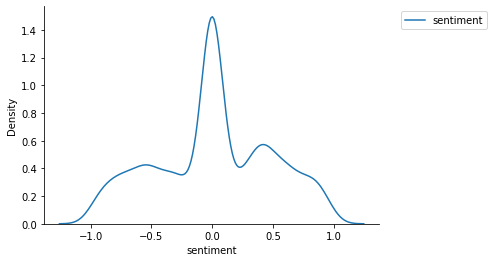

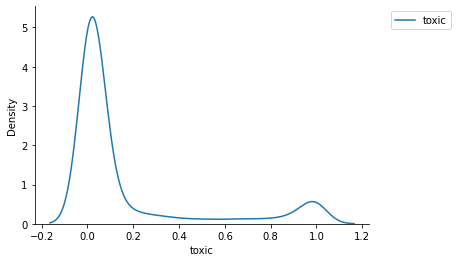

,sentiment,toxic
count,175733.000000,175733.000000
mean,0.028740,0.162447
std,0.477631,0.300050
min,-0.999700,0.000010
25%,-0.296000,0.012287
50%,0.000000,0.023351
75%,0.401900,0.089885
max,0.999200,1.000000


In [ ]:
print("sentiment and toxicity per post\n")
sns.kdeplot(df['sentiment'].sample(5000), label='sentiment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

sns.kdeplot(df['toxic'].sample(5000), label='toxic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

df.loc[:, ['sentiment', 'toxic']].describe()

sentiment and toxicity per thread



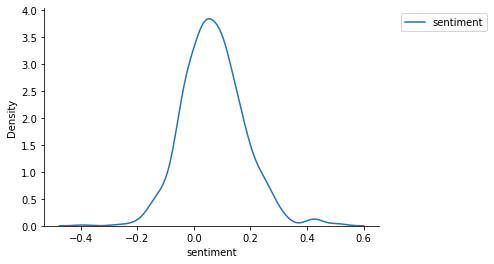

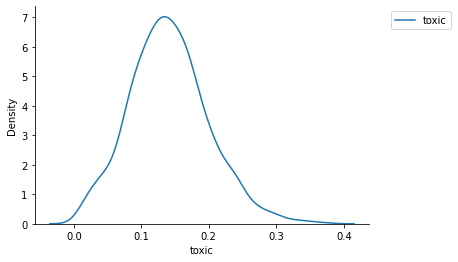

,sentiment,toxic
count,1007.000000,1007.000000
mean,0.069946,0.141082
std,0.108338,0.058414
min,-0.394469,0.008396
25%,-0.001033,0.101506
50%,0.063579,0.138104
75%,0.134019,0.175216
max,0.519470,0.371368


In [ ]:
print("sentiment and toxicity per thread\n")
df_agg = df.loc[:, ['thread', 'sentiment', 'toxic']].groupby('thread', as_index=False).mean()
sns.kdeplot(df_agg['sentiment'], label='sentiment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

sns.kdeplot(df_agg['toxic'], label='toxic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

df_agg.loc[:, ['sentiment', 'toxic']].describe()

sentiment and toxicity per streamer



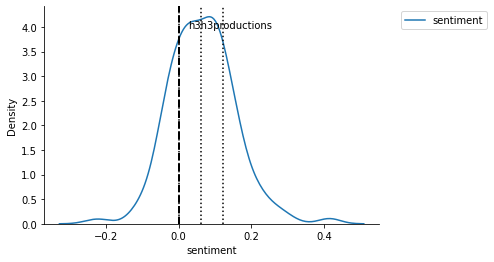

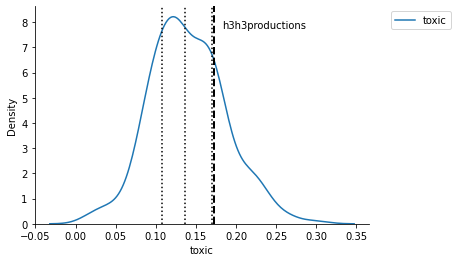

,sentiment,toxic
count,246.000000,246.000000
mean,0.065299,0.140166
std,0.090978,0.047115
min,-0.237075,0.014895
25%,0.001519,0.107511
50%,0.062376,0.136131
75%,0.121816,0.170563
max,0.417916,0.300106


In [ ]:
print("sentiment and toxicity per streamer\n")
df_agg = df.loc[:, ['target_streamer', 'sentiment', 'toxic']].groupby('target_streamer', as_index=False).mean()

# get central tendency
toxic_median = df_agg['toxic'].median()
sentiment_median = df_agg['sentiment'].median()
toxic_q25 = df_agg['toxic'].quantile(.25)
sentiment_q25 = df_agg['sentiment'].quantile(.25)
toxic_q75 = df_agg['toxic'].quantile(.75)
sentiment_q75 = df_agg['sentiment'].quantile(.75)

df_streamer = df_agg.sample(1)
# streamer = 'Trainwreckstv'
# df_streamer = df_agg.loc[df_agg['target_streamer']==streamer]
streamer_str = df_streamer['target_streamer'].values[0]
toxic_marker = df_streamer['toxic'].values[0]
sentiment_marker = df_streamer['sentiment'].values[0]

# plot
fig = sns.kdeplot(df_agg['sentiment'], label='sentiment')
x1, x2 = fig.get_xlim()
x_diff = x2-x1
y1, y2 = fig.get_ylim()
y_diff = y2-y1
plt.text(sentiment_marker+(.025*x_diff), y2*(0.9), streamer_str)
plt.axvline(sentiment_median, c='k', ls=':')
plt.axvline(sentiment_q25, c='k', ls=':')
plt.axvline(sentiment_q75, c='k', ls=':')
plt.axvline(sentiment_marker, c='k', ls='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

fig = sns.kdeplot(df_agg['toxic'], label='toxic')
x1, x2 = fig.get_xlim()
x_diff = x2-x1
y1, y2 = fig.get_ylim()
y_diff = y2-y1
plt.text(toxic_marker+(.025*x_diff), y2*(0.9), streamer_str)
plt.axvline(toxic_median, c='k', ls=':')
plt.axvline(toxic_q25, c='k', ls=':')
plt.axvline(toxic_q75, c='k', ls=':')
plt.axvline(toxic_marker, c='k', ls='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

df_agg.loc[:, ['sentiment', 'toxic']].describe()

sentiment and toxicity per category



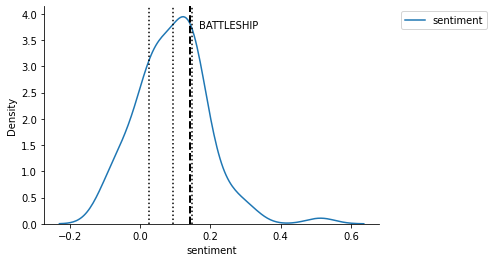

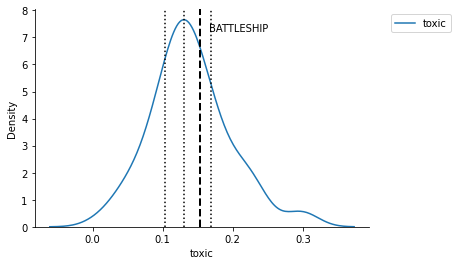

,sentiment,toxic
count,91.000000,91.000000
mean,0.091839,0.139986
std,0.101048,0.056994
min,-0.105772,0.008396
25%,0.026445,0.103095
50%,0.094675,0.130110
75%,0.146694,0.168730
max,0.512950,0.303826


In [ ]:
print("sentiment and toxicity per category\n")
df_agg = df.loc[:, ['target_category', 'sentiment', 'toxic']].groupby('target_category', as_index=False).mean()

# get central tendency
toxic_median = df_agg['toxic'].median()
sentiment_median = df_agg['sentiment'].median()
toxic_q25 = df_agg['toxic'].quantile(.25)
sentiment_q25 = df_agg['sentiment'].quantile(.25)
toxic_q75 = df_agg['toxic'].quantile(.75)
sentiment_q75 = df_agg['sentiment'].quantile(.75)

df_streamer = df_agg.sample(1)
# # streamer = 'Trainwreckstv'
# # df_streamer = df_agg.loc[df_agg['target_streamer']==streamer]
streamer_str = df_streamer['target_category'].values[0]
toxic_marker = df_streamer['toxic'].values[0]
sentiment_marker = df_streamer['sentiment'].values[0]

# plot
fig = sns.kdeplot(df_agg['sentiment'], label='sentiment')
x1, x2 = fig.get_xlim()
x_diff = x2-x1
y1, y2 = fig.get_ylim()
y_diff = y2-y1
plt.text(sentiment_marker+(.025*x_diff), y2*(0.9), streamer_str)
plt.axvline(sentiment_median, c='k', ls=':')
plt.axvline(sentiment_q25, c='k', ls=':')
plt.axvline(sentiment_q75, c='k', ls=':')
plt.axvline(sentiment_marker, c='k', ls='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

fig = sns.kdeplot(df_agg['toxic'], label='toxic')
x1, x2 = fig.get_xlim()
x_diff = x2-x1
y1, y2 = fig.get_ylim()
y_diff = y2-y1
plt.text(toxic_marker+(.025*x_diff), y2*(0.9), streamer_str)
plt.axvline(toxic_median, c='k', ls=':')
plt.axvline(toxic_q25, c='k', ls=':')
plt.axvline(toxic_q75, c='k', ls=':')
plt.axvline(toxic_marker, c='k', ls='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

df_agg.loc[:, ['sentiment', 'toxic']].describe()

In [ ]:
# is a specific thread more or less toxic for the avg thread / target streamer / target category?

# thread agg
_thread_date = df.loc[:, ['thread', 'target_streamer', 'target_category', 'date']].sort_values('date').drop_duplicates(subset=['thread'])
_thread_date_today = df_day.loc[:, ['thread', 'target_streamer', 'target_category', 'date']].sort_values('date').drop_duplicates(subset=['thread'])

df_thread = (df
             .loc[:, ['thread', 'sentiment', 'toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
             .groupby('thread', as_index=False)
             .mean()
             .merge(_thread_date))

df_thread_today = (df_day
             .loc[:, ['thread', 'sentiment', 'toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
             .groupby('thread', as_index=False)
             .mean()
             .merge(_thread_date_today))

# streamer agg
df_streamer = (df
               .loc[:, ['target_streamer', 'sentiment', 'toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
               .groupby('target_streamer', as_index=False)
               .mean())

for col in ['sentiment', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
  df_thread[col] = pd.Series(detrend(df_thread.loc[:, col]), index=df_thread.index)
  df_thread_today[col] = pd.Series(detrend(df_thread_today.loc[:, col]), index=df_thread_today.index)
  df_streamer[col] = pd.Series(detrend(df_streamer.loc[:, col]), index=df_streamer.index)

df_thread = median_shift(df_thread)
df_thread_today = median_shift(df_thread_today)
df_streamer = median_shift(df_streamer)
sentiment_scaler, toxic_scaler, severe_toxic_scaler, obscene_scaler, threat_scaler, insult_scaler, identity_hate_scaler = make_scalers(df_thread)

sentiment and toxicity per thread



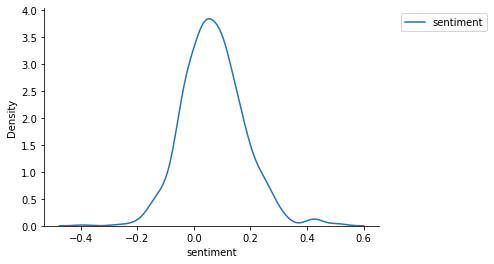

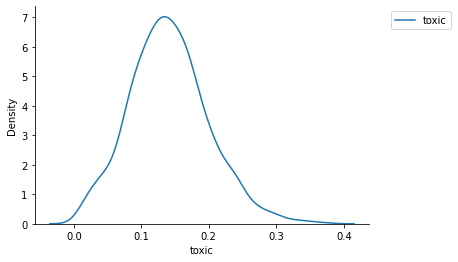

detrended sentiment and toxicity per thread



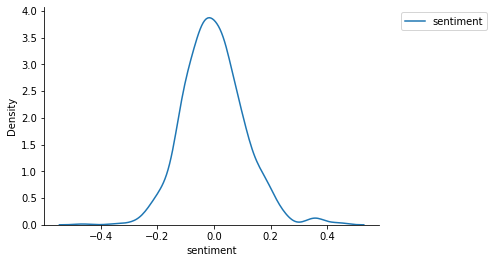

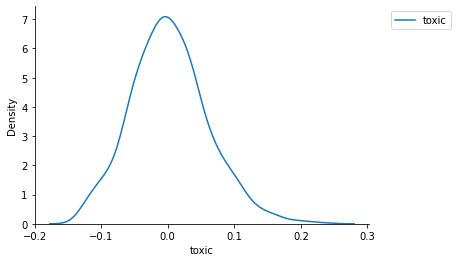

         sentiment        toxic
count  1007.000000  1007.000000
mean      0.069946     0.141082
std       0.108338     0.058414
min      -0.394469     0.008396
25%      -0.001033     0.101506
50%       0.063579     0.138104
75%       0.134019     0.175216
max       0.519470     0.371368

          sentiment        toxic
count  1.007000e+03  1007.000000
mean  -1.939032e-17     0.002645
std    1.082477e-01     0.058309
min   -4.638374e-01    -0.133352
25%   -7.048254e-02    -0.037204
50%   -6.460236e-03     0.000000
75%    6.179393e-02     0.037578
max    4.471829e-01     0.236279


In [ ]:
print("sentiment and toxicity per thread\n")
df_agg = df.loc[:, ['thread', 'sentiment', 'toxic']].groupby('thread', as_index=False).mean()
sns.kdeplot(df_agg['sentiment'], label='sentiment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

sns.kdeplot(df_agg['toxic'], label='toxic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()


print("detrended sentiment and toxicity per thread\n")
sns.kdeplot(df_thread['sentiment'], label='sentiment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

sns.kdeplot(df_thread['toxic'], label='toxic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.show()

print(df_agg.loc[:, ['sentiment', 'toxic']].describe())
print()
print(df_thread.loc[:, ['sentiment', 'toxic']].describe())

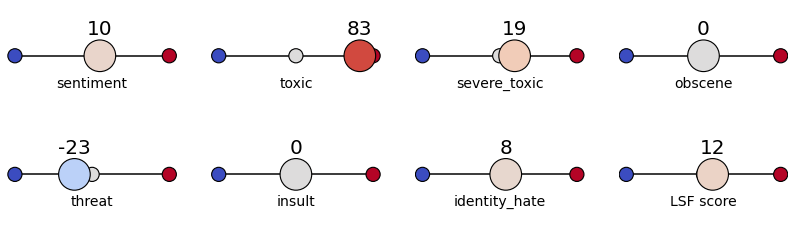

,date,thread,target_streamer,target_category,sentiment,toxic,severe_toxic,obscene,threat,insult,identity_hate,LSF score
0,2021-09-06,Lirik has some words of encouragement for he's...,LIRIK,Just Chatting,10.044917,82.820263,19.343968,0.0,-22.904203,0.0,7.850383,11.849698


In [ ]:
target_df = df_thread_today.copy()
target_sample = target_df.sample(1)
target_sample_cols = ['date', 'thread', 'target_streamer', 'target_category']
toxic_cols = ['sentiment', 'toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate', 'LSF score']

_transform = [sentiment_scaler.transform(target_sample[['sentiment']])[0][0],
              toxic_scaler.transform(target_sample[['toxic']])[0][0],
              severe_toxic_scaler.transform(target_sample[['severe_toxic']])[0][0],
              obscene_scaler.transform(target_sample[['obscene']])[0][0],
              threat_scaler.transform(target_sample[['threat']])[0][0],
              insult_scaler.transform(target_sample[['insult']])[0][0],
              identity_hate_scaler.transform(target_sample[['identity_hate']])[0][0]]

# some shoddy math for this LSF score...
_transform = _transform + [_transform[0]*(1+_transform[3]) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[6]*4))) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[4]*3))) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[5]*2))) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[2])))]
# this is a sentiment*obscene transform to reflect obscenity increasing the sentiment
_transform[0] = _transform[0]*(1+_transform[3])

# for ez reading lul
_transform = [x*100 for x in _transform]
target_sample_scores = pd.DataFrame([target_sample.loc[:, target_sample_cols].values.tolist()[0]+_transform], columns=target_sample_cols+toxic_cols)
target_sample_scores.loc[:, ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']] = target_sample_scores.loc[:, ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']]

fig, ax = plt.subplots(2,4)
for idx, col in enumerate(toxic_cols):
  if idx<4:
    plot_score(target_sample_scores, col, ax=ax[0][idx])
  else:
    plot_score(target_sample_scores, col, ax=ax[1][idx-4])

plt.gcf().set_size_inches(14, plt.gcf().get_size_inches()[1])
plt.show()

target_sample_scores

# of threads for zackrawrr: 4


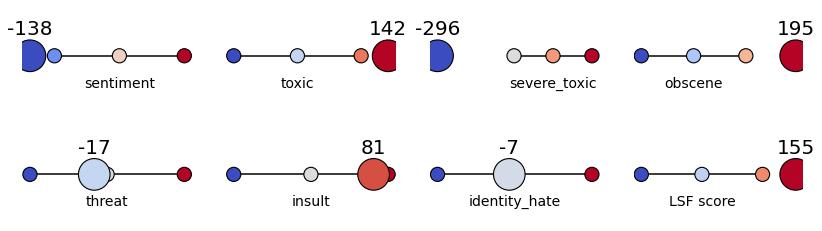

,date,thread,target_streamer,target_category,sentiment,toxic,severe_toxic,obscene,threat,insult,identity_hate,LSF score
0,2021-09-06,zackrawrr - Asmon & Fed,zackrawrr,Just Chatting,-137.70851,142.396576,-296.397438,195.353081,-16.704992,81.178124,-7.045236,154.697763


In [ ]:
df_streamer = df_thread.loc[df_thread['target_streamer']==target_sample['target_streamer'].values[0]]
print(f"# of threads for {target_sample['target_streamer'].values[0]}: {df_streamer.shape[0]}")
sentiment_scaler, toxic_scaler, severe_toxic_scaler, obscene_scaler, threat_scaler, insult_scaler, identity_hate_scaler = make_scalers(df_streamer)

target_sample_cols = ['date', 'thread', 'target_streamer', 'target_category']
toxic_cols = ['sentiment', 'toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate', 'LSF score']

_transform = [sentiment_scaler.transform(target_sample[['sentiment']])[0][0],
              toxic_scaler.transform(target_sample[['toxic']])[0][0],
              severe_toxic_scaler.transform(target_sample[['severe_toxic']])[0][0],
              obscene_scaler.transform(target_sample[['obscene']])[0][0],
              threat_scaler.transform(target_sample[['threat']])[0][0],
              insult_scaler.transform(target_sample[['insult']])[0][0],
              identity_hate_scaler.transform(target_sample[['identity_hate']])[0][0]]

# some shoddy math for this LSF score...
_transform = _transform + [_transform[0]*(1+_transform[3]) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[6]*4))) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[4]*3))) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[5]*2))) - (abs(_transform[0]*(1+_transform[3]))-(abs(_transform[0]*(1+_transform[3])) * (1-_transform[2])))]
# this is a sentiment*obscene transform to reflect obscenity increasing the sentiment
_transform[0] = _transform[0]*(1+_transform[3])

# for ez reading lul
_transform = [x*100 for x in _transform]
target_sample_scores = pd.DataFrame([target_sample.loc[:, target_sample_cols].values.tolist()[0]+_transform], columns=target_sample_cols+toxic_cols)
target_sample_scores.loc[:, ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']] = target_sample_scores.loc[:, ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']]

fig, ax = plt.subplots(2,4)
for idx, col in enumerate(toxic_cols):
  if idx<4:
    plot_score(target_sample_scores, col, ax=ax[0][idx])
  else:
    plot_score(target_sample_scores, col, ax=ax[1][idx-4])

plt.gcf().set_size_inches(14, plt.gcf().get_size_inches()[1])
plt.show()

target_sample_scores

In [ ]:
target_sample_scores['thread'].values[0]

'Northernlion on why he thinks hasan will win mogul money.'

In [ ]:
df.columns.values

array(['thread', 'flair', 'upvotes', 'upvote_ratio', 'num_comments',
       'cid', 'dt', 'comment', 'sentiment', 'toxic', 'severe_toxic',
       'obscene', 'threat', 'insult', 'identity_hate', 'datetime',
       'target_streamer', 'target_category', 'date'], dtype=object)

In [ ]:
df_agg = (df
          .loc[:, ['thread', 'num_comments', 'sentiment', 'toxic',
                   'severe_toxic', 'obscene', 'threat', 'insult',
                   'identity_hate']]
          .groupby(['thread', 'num_comments'],
                   as_index=False)
          .mean())
df_agg['bins'] = pd.cut(df_agg['num_comments'], bins=20)
df_agg.sample(5)

,thread,num_comments,sentiment,toxic,severe_toxic,obscene,threat,insult,identity_hate,bins
867,Why Northernlion does not have 5Head enabled.,22,0.177886,0.108442,0.002207,0.060829,0.000417,0.058824,0.001467,"(-0.152, 160.6]"
556,Nadeshot discovers the meaning of his slang du...,30,0.220414,0.083982,0.001786,0.051406,0.000135,0.010254,0.000806,"(-0.152, 160.6]"
730,"Sodapoppin testing 300 year old MRE, instantly...",33,0.072934,0.159204,0.001935,0.099014,0.000226,0.069609,0.001553,"(-0.152, 160.6]"
401,Just an average Church session on Twitch,108,0.104570,0.098311,0.000787,0.033701,0.000146,0.027569,0.001100,"(-0.152, 160.6]"
347,Hasan's response,338,0.022536,0.198731,0.004465,0.103187,0.005943,0.070083,0.002650,"(318.2, 475.8]"


In [ ]:
df_agg['bins_code'] = df_agg['bins'].cat.codes

In [ ]:
df_agg.loc[:, ['bins', 'bins_code']].drop_duplicates().sort_values('bins_code')

,bins,bins_code
0,"(-0.152, 160.6]",0
18,"(160.6, 318.2]",1
19,"(318.2, 475.8]",2
40,"(475.8, 633.4]",3
79,"(633.4, 791.0]",4
21,"(791.0, 948.6]",5
2,"(948.6, 1106.2]",6
42,"(1106.2, 1263.8]",7
61,"(1263.8, 1421.4]",8
29,"(1421.4, 1579.0]",9


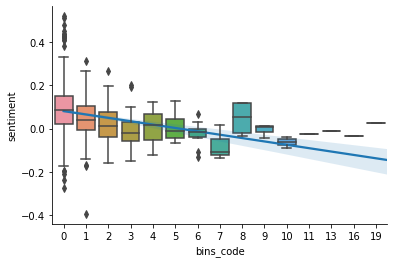

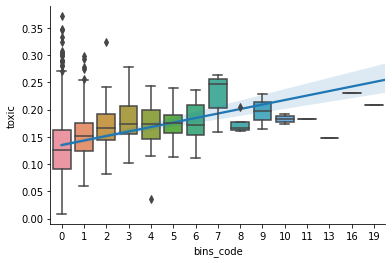

In [ ]:
sns.regplot(data=df_agg, x='bins_code', y='sentiment', scatter=False)
sns.boxplot(data=df_agg, x='bins_code', y='sentiment', zorder=2)
sns.despine()
plt.show()

sns.regplot(data=df_agg, x='bins_code', y='toxic', scatter=False)
sns.boxplot(data=df_agg, x='bins_code', y='toxic', zorder=2)
sns.despine()
plt.show()

In [ ]:
from scipy.signal import detrend
from numpy.random import default_rng

In [ ]:
df_agg.loc[:, ['num_comments', 'sentiment']].shape

(1007, 2)

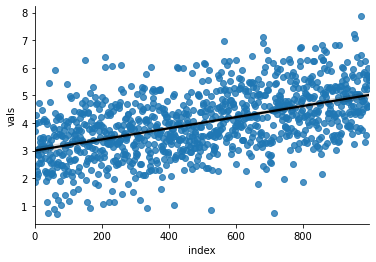

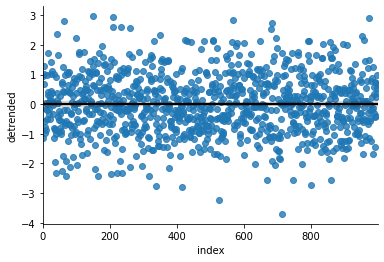

In [ ]:
rng = default_rng()
npoints = 1000
noise = rng.standard_normal(npoints)
x = 3 + 2*np.linspace(0, 1, npoints) + noise
df_plt = pd.Series(x).to_frame().reset_index(drop=True).reset_index().rename(columns={0:'vals'})
df_plt['detrended'] = pd.Series(detrend(df_plt.loc[:, 'vals']), index=df_plt.index)

sns.regplot(data=df_plt, x='index', y='vals', line_kws={'color':'k'})
sns.despine()
plt.show()

sns.regplot(data=df_plt, x='index', y='detrended', line_kws={'color':'k'})
sns.despine()
plt.show()

In [ ]:
def plot_shit(df_plt, col=None):
  sns.regplot(data=df_plt, x='num_comments', y=col, line_kws={'color':'k'})
  sns.despine()
  plt.show()

  sns.regplot(data=df_plt, x='num_comments', y=f'{col}_detrended', line_kws={'color':'k'})
  sns.despine()
  plt.show()

  sns.regplot(data=df_plt, x='bins_code', y=col, scatter=False)
  sns.boxplot(data=df_plt, x='bins_code', y=col, zorder=2)
  sns.despine()
  plt.show()

  sns.regplot(data=df_plt, x='bins_code', y=f'{col}_detrended', scatter=False)
  sns.boxplot(data=df_plt, x='bins_code', y=f'{col}_detrended', zorder=2)
  sns.despine()
  plt.show()


sentiment


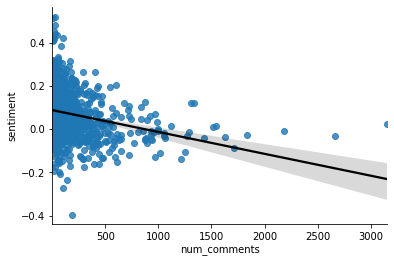

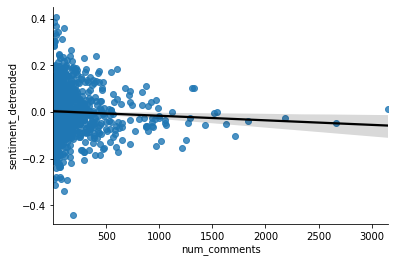

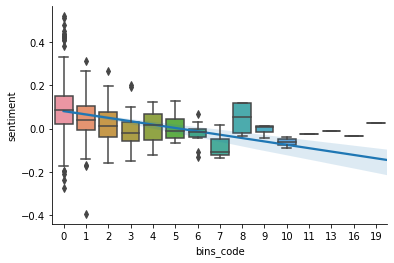

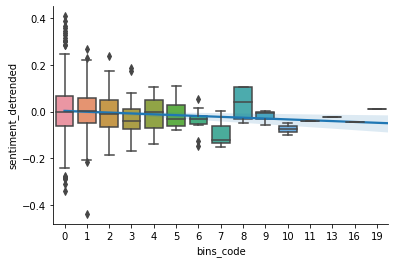


toxic


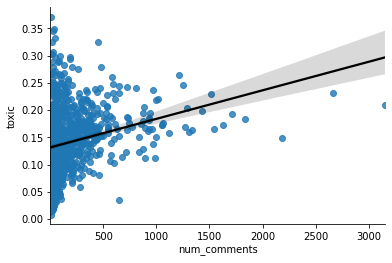

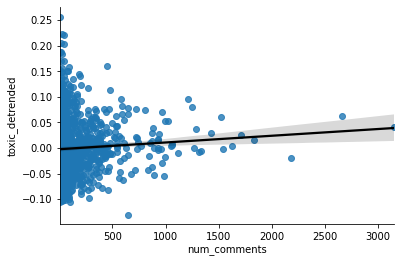

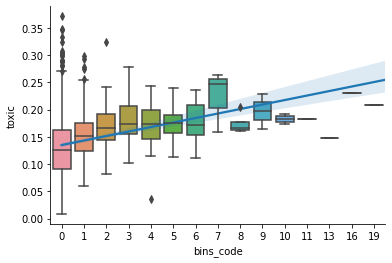

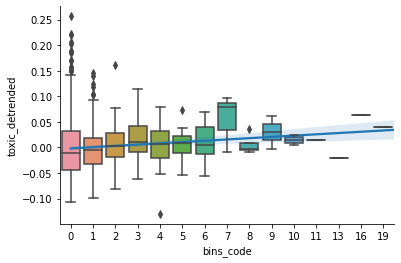

In [ ]:
df_plt = df_agg.loc[:, ['num_comments', 'sentiment', 'toxic']].sort_values('num_comments')
_df_plt = pd.DataFrame(detrend(df_plt.loc[:, ['sentiment', 'toxic']]), index=df_plt.index, columns=['sentiment', 'toxic'])
for col in ['sentiment', 'toxic']:
  df_plt[f'{col}_detrended'] = pd.Series(detrend(df_plt.loc[:, col]), index=df_plt.index)
df_plt['bins'] = pd.cut(df_plt['num_comments'], bins=20)
df_plt['bins_code'] = df_plt['bins'].cat.codes


print('sentiment')
plot_shit(df_plt, col='sentiment')

print('\ntoxic')
plot_shit(df_plt, col='toxic')


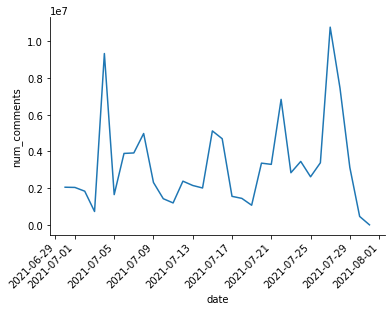

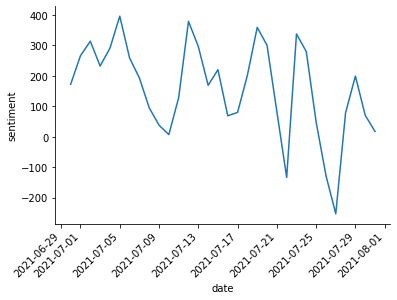

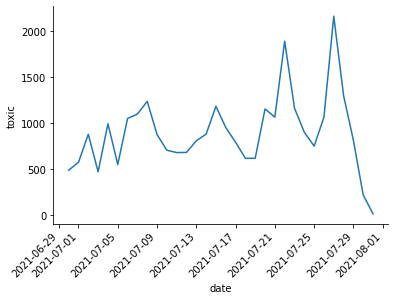

In [ ]:
sns.lineplot(data=df_agg, x='date', y='num_comments')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

sns.lineplot(data=df_agg, x='date', y='sentiment')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

sns.lineplot(data=df_agg, x='date', y='toxic')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

# commented out shit

In [ ]:
# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1 )
# vec.fit(train['comment_text'])

# with open(f'{comments_directory}/toxicity-tfidf.vec', 'wb') as handle:
#   pickle.dump(vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# query =  reddit.subreddit('LivestreamFail').top('all', limit = 100)

# for post in query:
#     thread = str(post.name)
#     comments = post.comments

In [ ]:
# #TRAINS THE TOXIC COMMENT IDENTIFIER MODELS
# train = pd.read_csv(f'{comments_directory}/toxicity.csv')
# label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# train['none'] = 1-train[label_cols].max(axis=1)

# COMMENT = 'comment_text'
# train[COMMENT].fillna("unknown", inplace=True)

# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1 )
# trn_term_doc = vec.fit_transform(train[COMMENT])

# toxicity_models = {}
# for j in tqdm(label_cols):
#   m,r = get_mdl(train[j], trn_term_doc)
#   toxicity_models[j] = [m,r]

# with open(f'{comments_directory}/toxicity.model', 'wb') as handle:
#   pickle.dump(toxicity_models, handle, protocol=pickle.HIGHEST_PROTOCOL)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# with open(f'{comments_directory}/comments.csv', 'w+', newline='') as csvfile:
#     # initiate csv writer
#     comment_writer = csv.writer(csvfile, delimiter='\t',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     # write header
#     comment_writer.writerow(["timestamp", "team", "body", "length",
#                              "sentiment", "subreddit", "boo", "id", "body_full"])

# # setup multireddit
# team_subreddits = ["KansasCityChiefs", "raiders", "DenverBroncos", "Chargers", "Colts",
#                    "Tennesseetitans", "Texans", "Jaguars", "bengals", "steelers",
#                    "ravens", "Browns", "miamidolphins", "nyjets", "buffalobills",
#                    "Patriots", "cowboys", "NYGiants", "eagles", "Redskins", "CHIBears",
#                    "GreenBayPackers", "detroitlions", "minnesotavikings", "falcons",
#                    "Saints", "panthers", "buccaneers" ,"AZCardinals", "49ers",
#                    "LosAngelesRams", "Seahawks"]

# team_names = ["Chiefs", "Raiders", "Broncos", "Chargers", "Colts", "Titans",
#               "Texans", "Jaguars", "Bengals", "Steelers", "Ravens", "Browns",
#               "Dolphins", "Jets", "Bills", "Patriots", "Cowboys", "Giants",
#               "Eagles", "Redskins", "Bears", "Packers", "Lions", "Vikings",
#               "Falcons", "Saints", "Panthers", "Buccaneers", "Cardinals",
#               "49ers", "Rams", "Seahawks"]
# teams_dict = dict(zip(team_subreddits,team_names))

# while(True):
#     # loop through comments
#     n = 0
#     behind_flag = False
#     for idx, comment in tqdm(enumerate(reddit.subreddit("+".join(team_subreddits)+"+nfl").stream.comments(skip_existing=True))):
#         ## this is for testing. 5 iterations = ~1 min of comments
#         # if idx==50:
#         #     break
#         # grab time and id
#         comment_time = comment.created_utc #time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(comment.created_utc))
#         comment_id = comment.id

#         # control for falling behind
#         if time.time() - comment_time > 30 and not behind_flag:
#             print("BEHIND, INITIATING CATCHUP")
#             behind_flag = True
#             continue
#         elif behind_flag:
#             if time.time() - comment_time <= 5:
#                 print("CAUGHT UP, RESUMING AS USUAL")
#                 behind_flag = False
#             continue

#         # grab text and remove new lines
#         comment_text = comment.body.replace("\n", "")
#         comment_text = comment_text.replace("\t", "")
#         comment_text = comment_text.split('http')[0]
#         if len(comment_text) == 0:
#           comment_text = '[Link removed]'
#         comment_text = re.sub(r"[^a-zA-Z0-9 !?,.()]+", '', comment_text)
#         comment_length = len(comment_text)

#         # remove elongations from text

#         try:
#             comment_text_clean = remove_elongations_bro(comment_text.lower())

#             # this is the old code -nw 4/20/21
#             # comment_text_clean = textclean.replace_word_elongation(comment_text.lower())[0]
#             # if "bo" in comment_text_clean.split(" ") or comment_text_clean == "bo":  ### GO RAVENS - Disclaimer: @SeanFromSeabeck blackmailed me to put this here
#             #     comment_text_clean = comment_text_clean.replace("bo","boo")
#         except:
#             print("ERROR: WORD ELONGATION CLEANER FAILED")

#         # grab subreddit team
#         comment_subr = comment.subreddit.display_name
#         if comment_subr == "nfl":
#             comment_team = comment.author_flair_text
#             if (comment_team not in team_names):
#               continue
#         else:
#             comment_team = teams_dict[comment_subr]
#             comment_subr = "team"

#         # get sentiment
#         try:
#             # check with the revision history on what this old sentiment package was
#             #comment_sent = getSentiment(comment.body)
#             comment_sent = vader.polarity_scores(comment_text_clean)['compound']
#         except:
#             print("ERROR: SENTIMENT ANALYSIS FAILED")

#         # sentiment heuristics
#         if comment_text_clean in ["let's go", "lets go", "fuck yes",
#                                   "fuck yeah", 'lfg', "let's fucking go",
#                                   'lets fucking go']:
#             comment_sent = .7
#         elif comment_text_clean in ["boo"]:
#             comment_sent = -1

#         # get goodell boo-meter
#         if "boo" in comment_text_clean.split(" ") or comment_text_clean == "boo":
#             comment_boo = 1
#         else:
#             comment_boo = 0

#         # visualize and write
#         print([comment_time, comment_team, comment_text,
#                comment_length, comment_sent, comment_subr])

#         # filter out profanity
#         try:
#             comment_text_censored = censor_profanity(comment_text)

#             # from the old repo -nw 4/21/21
#             # comment_text_censored = pf.censor(comment_text)
#         except:
#             print("UNSUPPORTED CHARACTER IN PROFANITY CENSOR")
#             continue


#         ## keep track of chunks to cleanup after chunk size comments
#         if n >= chunk_size:
#             print('CHUNK SIZE HIT, STARTING NEW FILE')
#             t = time.time()
#             n = -1
#             with open(f'{comments_directory}/comments_temp.csv', 'w', newline='') as csvfile:
#                 # initiate csv writer
#                 comment_writer = csv.writer(csvfile, delimiter='\t',
#                                             quotechar='|',
#                                             quoting=csv.QUOTE_MINIMAL)
#                 # write header
#                 comment_writer.writerow(["timestamp", "team", "body", "length",
#                                          "sentiment", "subreddit", "boo", "id",
#                                          "body_full"])

#         ## write to temp file
#         if n == -1:
#             try:
#                 with open(f'{comments_directory}/comments_temp.csv', 'a', newline='') as csvfile:
#                     # initiate csv writer
#                     comment_writer = csv.writer(csvfile, delimiter='\t',
#                                                 quotechar='|',
#                                                 quoting=csv.QUOTE_MINIMAL)

#                     comment_writer.writerow([comment_time, comment_team,
#                                              comment_text_censored,
#                                              comment_length, comment_sent,
#                                              comment_subr, comment_boo,
#                                              comment_id, comment_text])
#             except:
#                 print("ERROR: CONFLICT IN USING TEMP FILE OR UNSUPPORTED CHARACTER")

#         # write file
#         try:
#             with open(f'{comments_directory}/comments.csv', 'a', newline='') as csvfile:
#                 # initiate csv writer
#                 comment_writer = csv.writer(csvfile, delimiter='\t',
#                                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#                 comment_writer.writerow([comment_time, comment_team,
#                                          comment_text_censored, comment_length,
#                                          comment_sent, comment_subr,
#                                          comment_boo, comment_id, comment_text])
#                 if n !=-1 :
#                     n += 1
#         except:
#             print("ERROR: CONFLICT IN USING FILE OR UNSUPPORTED CHARACTER")

#         ## write to new file after 2 minutes
#         if n == -1 and time.time() - t >= 15:
#             print("CHUNK TIME PASSED, FIXING FILE")
#             # swap files
#             os.popen(f'cp {comments_directory}/comments_temp.csv {comments_directory}/comments_restart.csv')
#             os.rename(f'{comments_directory}/comments.csv',
#                       f'{comments_directory}/chunks/comments_{str(num_chunks)}.csv')

#             os.rename(f'{comments_directory}/comments_temp.csv',
#                       f'{comments_directory}/comments.csv')

#             # update vars
#             n = 0
#             num_chunks += 1
#     ## this is for testing. 5 iterations = ~1 min of comments
#     # if idx==50:
#     #     break

#     # if 503 server overload, pause and try again
#     time.sleep(2)